## Import Dependencies

In [1]:
import tensorflow as tf
import os

2025-08-28 22:57:32.794160: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 22:57:32.878371: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 22:57:33.151873: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 22:57:33.234393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756402053.439382   25734 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756402053.48

In [2]:
#avoid OOM error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2025-08-28 22:57:39.746521: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

/tmp/ipykernel_25734/3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Remove dodgy images

In [4]:
data_dir = 'data'

In [5]:
os.listdir(data_dir)

['happy', 'sad']

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir,image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [8]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [9]:
import numpy as np
from matplotlib import pyplot as plt


In [10]:
data = tf.keras.utils.image_dataset_from_directory('data') #create a data pipeline

Found 206 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()  #access the data pipeline

In [12]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7fc4d8d699a0>)

In [13]:
#Get another batch from the iterator
batch = data_iterator.next()

In [14]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
#Class 1= SAD PEOPLE
#Class 0= HAPPY PEOPLE
batch[1]

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int32)

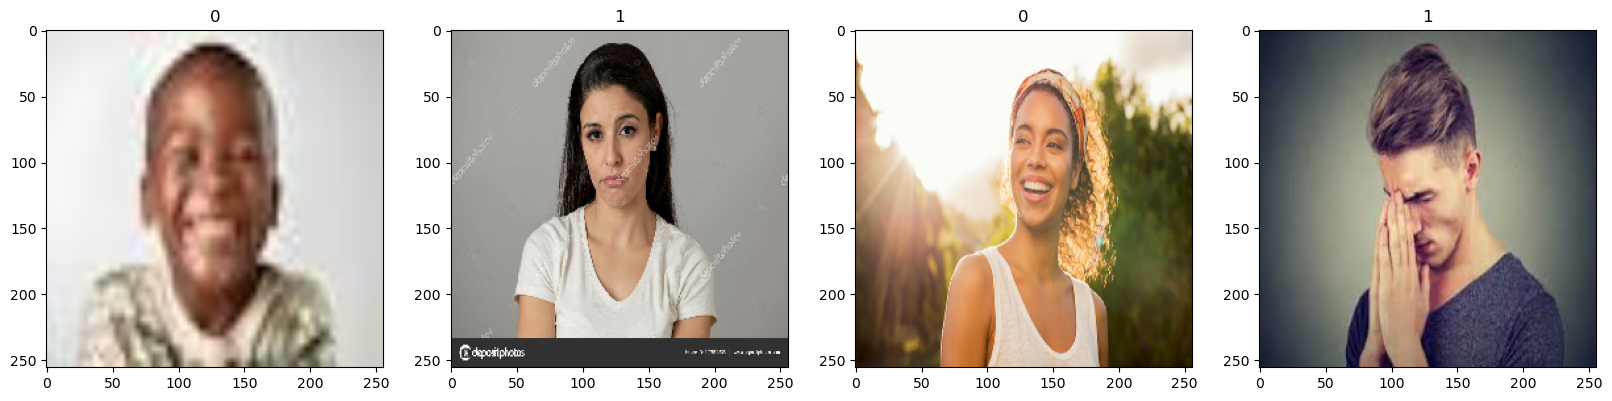

In [16]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
batch[0].max()

255.0

In [18]:
scaled = batch[0] / 255

In [19]:
scaled.min()

0.0

In [20]:
scaled.max()

1.0

## Preprocess Data

### Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y)) #transformation inside data pipeline

In [22]:
scaled_iterator = data.as_numpy_iterator()

In [23]:
batch = scaled_iterator.next()

In [24]:
batch[0].max() #checking

1.0

## Split Data

In [25]:
len(data)

7

In [26]:
train_size = int(len(data)*.7) #70%of the data to train
val_size = int(len(data)*.2) + 1 #20%of the data for validation
test_size = int(len(data)*.1) + 1 #10%of the data to test

In [27]:
train_size+val_size+test_size

7

In [28]:
#take and skip method for train, test and validation partition (only works with integer values, i,e length here)
train = data.take(train_size)
val= data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Learning Model 

### Build the model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [30]:
model = Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) #sigmoid outputs 0 or 1!

/home/matin/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [34]:
logdir = 'logs' 

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - accuracy: 0.5094 - loss: 0.7216 - val_accuracy: 0.6719 - val_loss: 0.6704
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6126 - loss: 0.6766

2025-08-28 22:57:53.752935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step - accuracy: 0.6073 - loss: 0.6746 - val_accuracy: 0.5781 - val_loss: 0.6646
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step - accuracy: 0.7448 - loss: 0.6206 - val_accuracy: 0.6094 - val_loss: 0.6174
Epoch 4/20


2025-08-28 22:57:59.193153: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.7396 - loss: 0.5266 - val_accuracy: 0.7969 - val_loss: 0.4388
Epoch 5/20


2025-08-28 22:58:01.952536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 0.7594 - loss: 0.4878 - val_accuracy: 0.9062 - val_loss: 0.4071
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - accuracy: 0.8281 - loss: 0.4557 - val_accuracy: 0.8750 - val_loss: 0.3524
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - accuracy: 0.8552 - loss: 0.3403 - val_accuracy: 0.9375 - val_loss: 0.2333
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.9125 - loss: 0.2942 - val_accuracy: 0.9688 - val_loss: 0.1595
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9616 - loss: 0.1436

2025-08-28 22:58:15.790275: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9521 - loss: 0.1572 - val_accuracy: 0.9844 - val_loss: 0.0905
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step - accuracy: 0.9594 - loss: 0.1153 - val_accuracy: 0.9688 - val_loss: 0.1432
Epoch 11/20


2025-08-28 22:58:19.755294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.9104 - loss: 0.2029 - val_accuracy: 0.9531 - val_loss: 0.1350
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.9563 - loss: 0.1460 - val_accuracy: 0.9844 - val_loss: 0.1092
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 0.9625 - loss: 0.1345 - val_accuracy: 1.0000 - val_loss: 0.0717
Epoch 14/20


2025-08-28 22:58:28.881483: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.9885 - loss: 0.0707 - val_accuracy: 1.0000 - val_loss: 0.0970
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.9885 - loss: 0.0828 - val_accuracy: 1.0000 - val_loss: 0.0339
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 1.0000 - loss: 0.0306

2025-08-28 22:58:39.263630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 1.0000 - val_loss: 0.0236
Epoch 17/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 18/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step - accuracy: 0.9937 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 19/20


2025-08-28 22:58:45.087405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 20/20


2025-08-28 22:58:48.074727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 1.0000 - loss: 0.0166

2025-08-28 22:58:50.849440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0114


In [37]:
hist.history

{'accuracy': [0.5,
  0.5859375,
  0.7109375,
  0.7578125,
  0.734375,
  0.84375,
  0.8515625,
  0.90625,
  0.9140625,
  0.953125,
  0.921875,
  0.9375,
  0.953125,
  0.984375,
  0.984375,
  1.0,
  1.0,
  0.984375,
  1.0,
  1.0],
 'loss': [0.7227221131324768,
  0.6669073104858398,
  0.6321442723274231,
  0.5251936912536621,
  0.5091474056243896,
  0.4256954789161682,
  0.33750641345977783,
  0.29353296756744385,
  0.2115415632724762,
  0.12723541259765625,
  0.18840165436267853,
  0.17040561139583588,
  0.1648879051208496,
  0.0811091810464859,
  0.07477924972772598,
  0.02793680503964424,
  0.015144623816013336,
  0.027705950662493706,
  0.008774517104029655,
  0.02082492783665657],
 'val_accuracy': [0.671875,
  0.578125,
  0.609375,
  0.796875,
  0.90625,
  0.875,
  0.9375,
  0.96875,
  0.984375,
  0.96875,
  0.953125,
  0.984375,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.6704282760620117,
  0.6645969152450562,
  0.6173760890960693,
  0.4387706518173218,

### Plot Performance

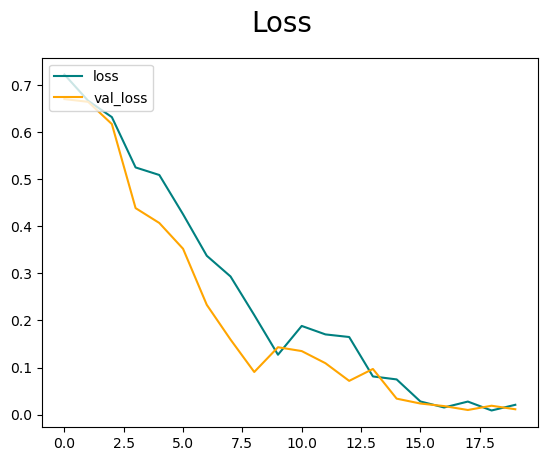

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color= 'teal', label='loss')
plt.plot(hist.history['val_loss'], color= 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

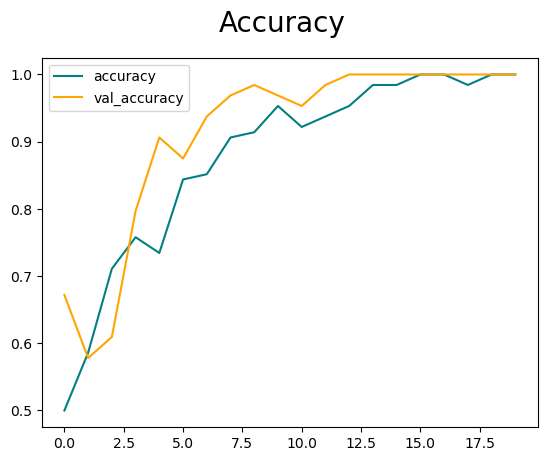

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

### Evaluate

In [41]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [42]:
pre = Precision()
re= Recall()
acc= BinaryAccuracy()

In [43]:
len(test)

1

In [44]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


2025-08-28 23:15:11.237607: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy:{acc.result().numpy}')

Precision:1.0, Recall: 1.0, Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


### Test

In [ ]:
#import cv2

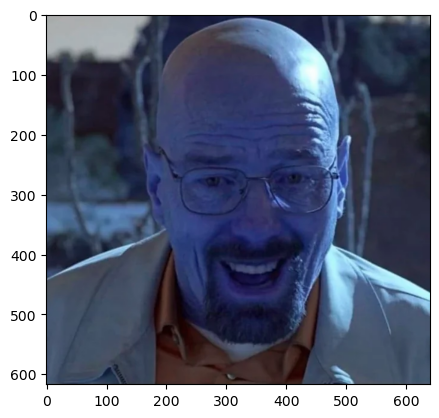

In [63]:
img = cv2.imread('happytest.jpg')
plt.imshow(img) #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for rgb color instead of bgr
plt.show()

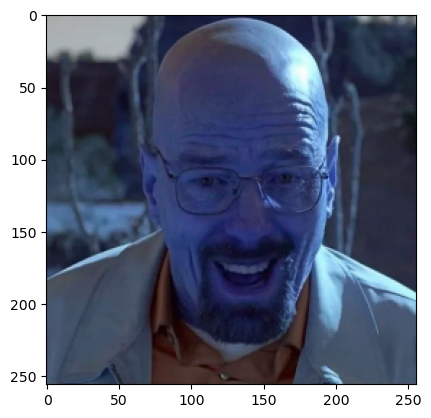

In [64]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [65]:
resize.shape

TensorShape([256, 256, 3])

In [66]:
#our model wants us to fit a batch of images so inorder to do this, we encapsulate in another set of arrays
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [67]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [68]:
yhat

array([[0.11477764]], dtype=float32)

In [61]:
#for the binary classification we already classified as 0:happy and 1:sad. Using the sigmoid activation function, we are keeping the threshold of 50%.

In [69]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


## Save the model

In [72]:
from tensorflow.keras.models import load_model

In [73]:
model.save(os.path.join('models','happysadmodel.h5'))

In [74]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [76]:
yhat_new=new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [77]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
